In [35]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from utils import *
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})

FILTER_DATA_DIR='../data_filterd/'

# matplotlib.rcdefaults()

figures saved to ../tmp/figures


In [7]:
DATA_DIR = '../data/'
dfj = get_df(DATA_DIR + 'pai_job_table.csv')
dft = get_df(DATA_DIR + 'pai_task_table.csv')
dfi = get_df(DATA_DIR + 'pai_instance_table.csv')
dfs = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfg = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm = get_df(DATA_DIR + 'pai_machine_metric.csv')

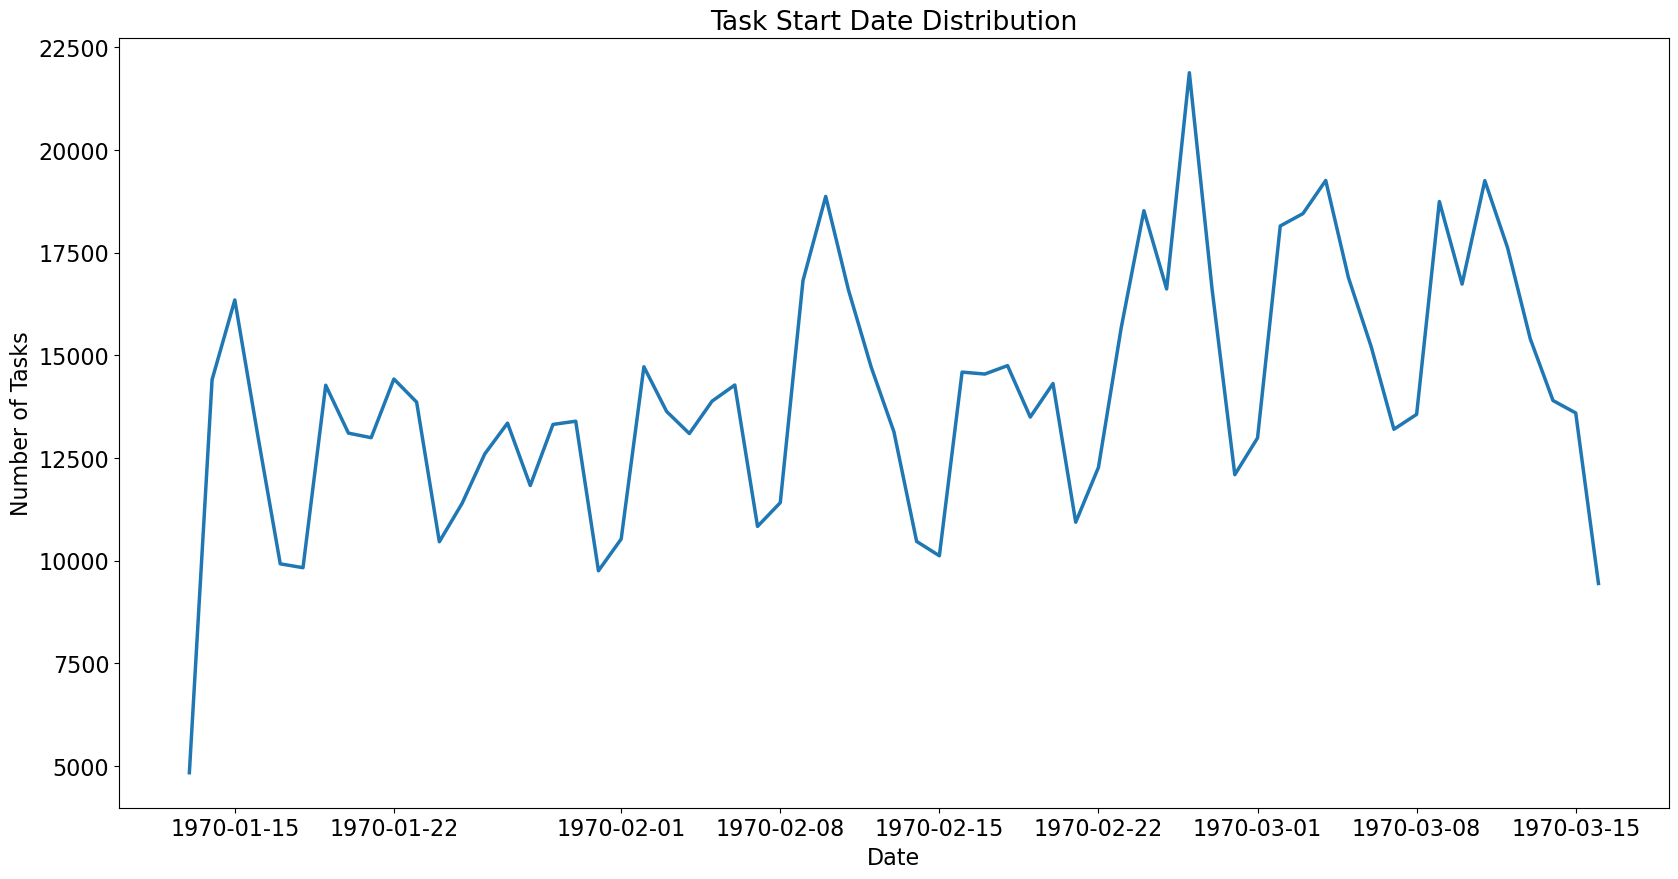

In [48]:

term_dft=dft[dft['status']=='Terminated']
# 插入一列在完成时间之后，计算任务运行时间（完成时间-创建时间）
term_dft['run_time'] = term_dft['end_time'] - term_dft['start_time']
term_dft.insert(term_dft.columns.get_loc('end_time')+1,'run_time',term_dft.pop('run_time'))
term_dft.sort_values(by='start_time',ascending=True,inplace=True)
# 新增三列，将三个时间戳转换为日期格式
term_dft['start_date'] = pd.to_datetime(term_dft['start_time'],unit='s')
term_dft['end_date'] = pd.to_datetime(term_dft['end_time'],unit='s')
# # 抛弃掉1/13日之前的数据
term_dft = term_dft[term_dft['start_date'] >= '1970-01-13']

# # 新增一列，task_type, 用于标记任务类型，分为三类：训练任务、推理任务和CPU任务
# term_dft.loc[term_dft['gpu_type'].isnull(),'task_type'] = 'CPU'
# term_dft.loc[term_dft['gpu_type'].notnull(),'task_type'] = 'Training'
# term_dft.loc[term_dft['gpu_type_spec'].notnull(),'task_type'] = 'Inference'


# 绘制任务开始日期的分布图，只取date中的日期，不要时间
term_dft['start_date'].dt.date.value_counts().sort_index().plot(kind='line',figsize=(20,10))
plt.title('Task Start Date Distribution')
plt.xlabel('Date')
plt.ylabel('Number of Tasks')
# plt.savefig(FILTER_DATA_DIR+'task_start_date_distribution.png')
plt.show()



# 保存处理后的数据
term_dft.to_csv(FILTER_DATA_DIR+'term_dft.csv',index=False) # optional


In [49]:
print(term_dft.shape)
# 打印gpu_type不为空
print(term_dft[term_dft['gpu_type'].notnull()].shape)

(884970, 13)
(732611, 13)


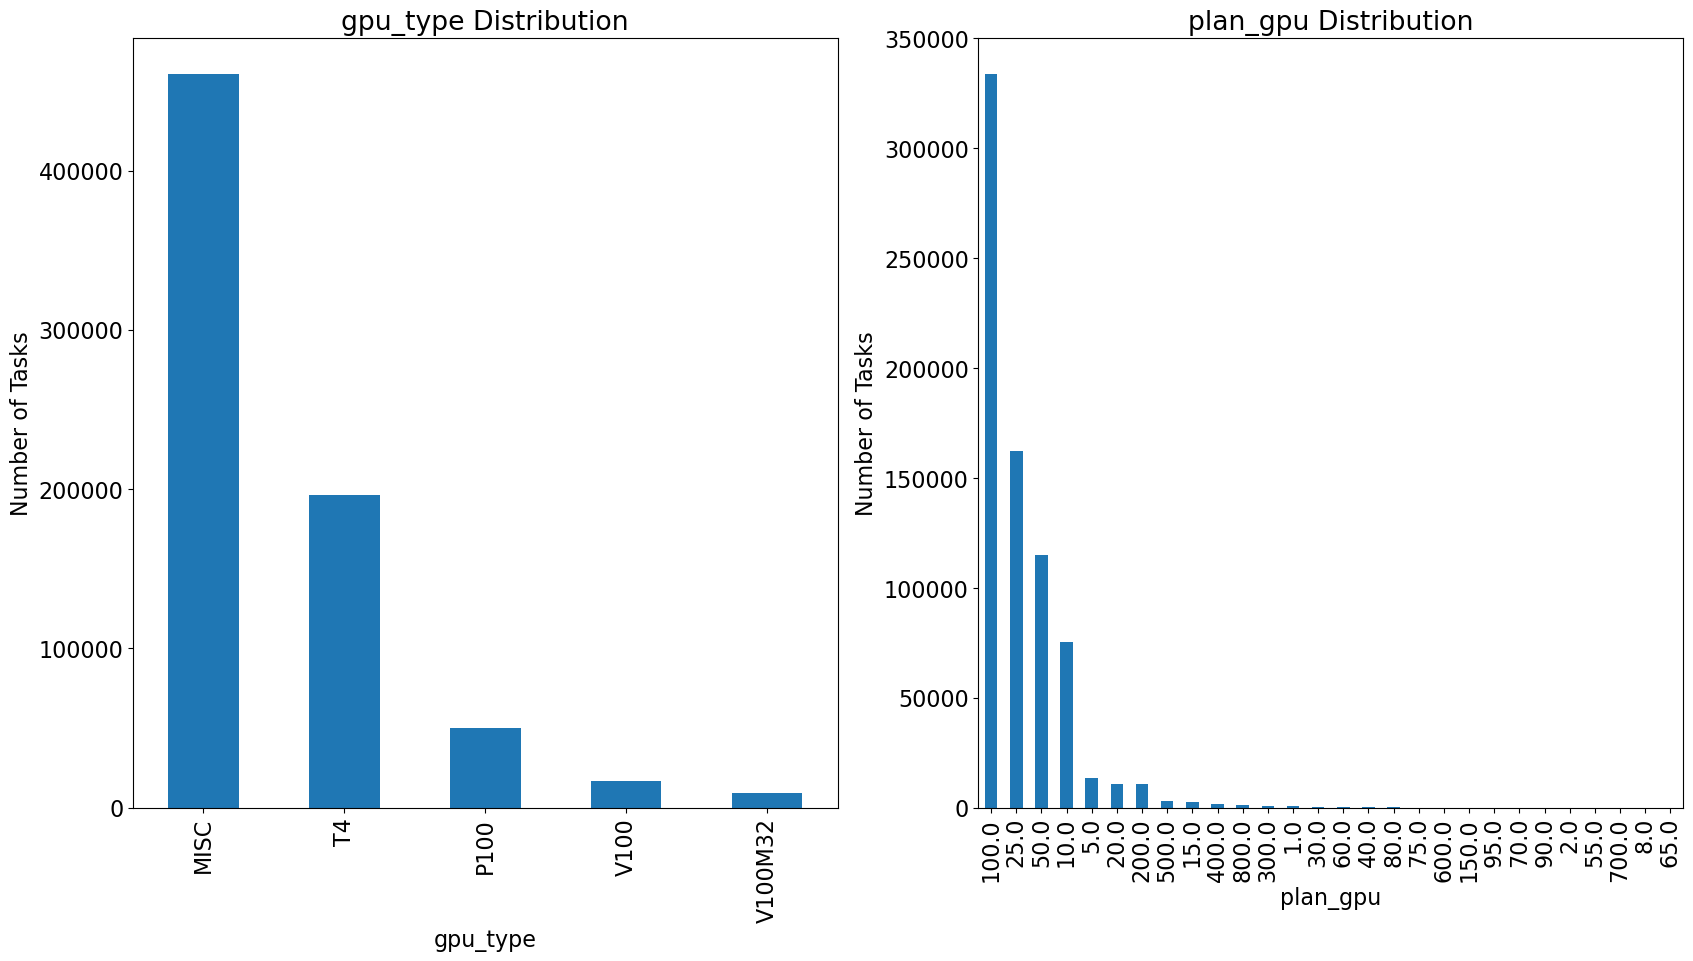

In [50]:
# 绘制gpu_type, plan_gpu的分布图
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
term_dft['gpu_type'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('gpu_type Distribution')
ax[0].set_xlabel('gpu_type')
ax[0].set_ylabel('Number of Tasks')
term_dft['plan_gpu'].value_counts().plot(kind='bar',ax=ax[1])
ax[1].set_title('plan_gpu Distribution')
# 按plan_gpu的值进行排序

ax[1].set_xlabel('plan_gpu')
ax[1].set_ylabel('Number of Tasks')
plt.show()

run_time median: 615.0
run_time mean: 5291.931548939342
plan_gpu median: 50.0
plan_gpu mean: 67.98495381587227
gpu_level median: 1.0
gpu_level mean: 1.7325087938892536
0.4424488678672098
0.4849788078222659


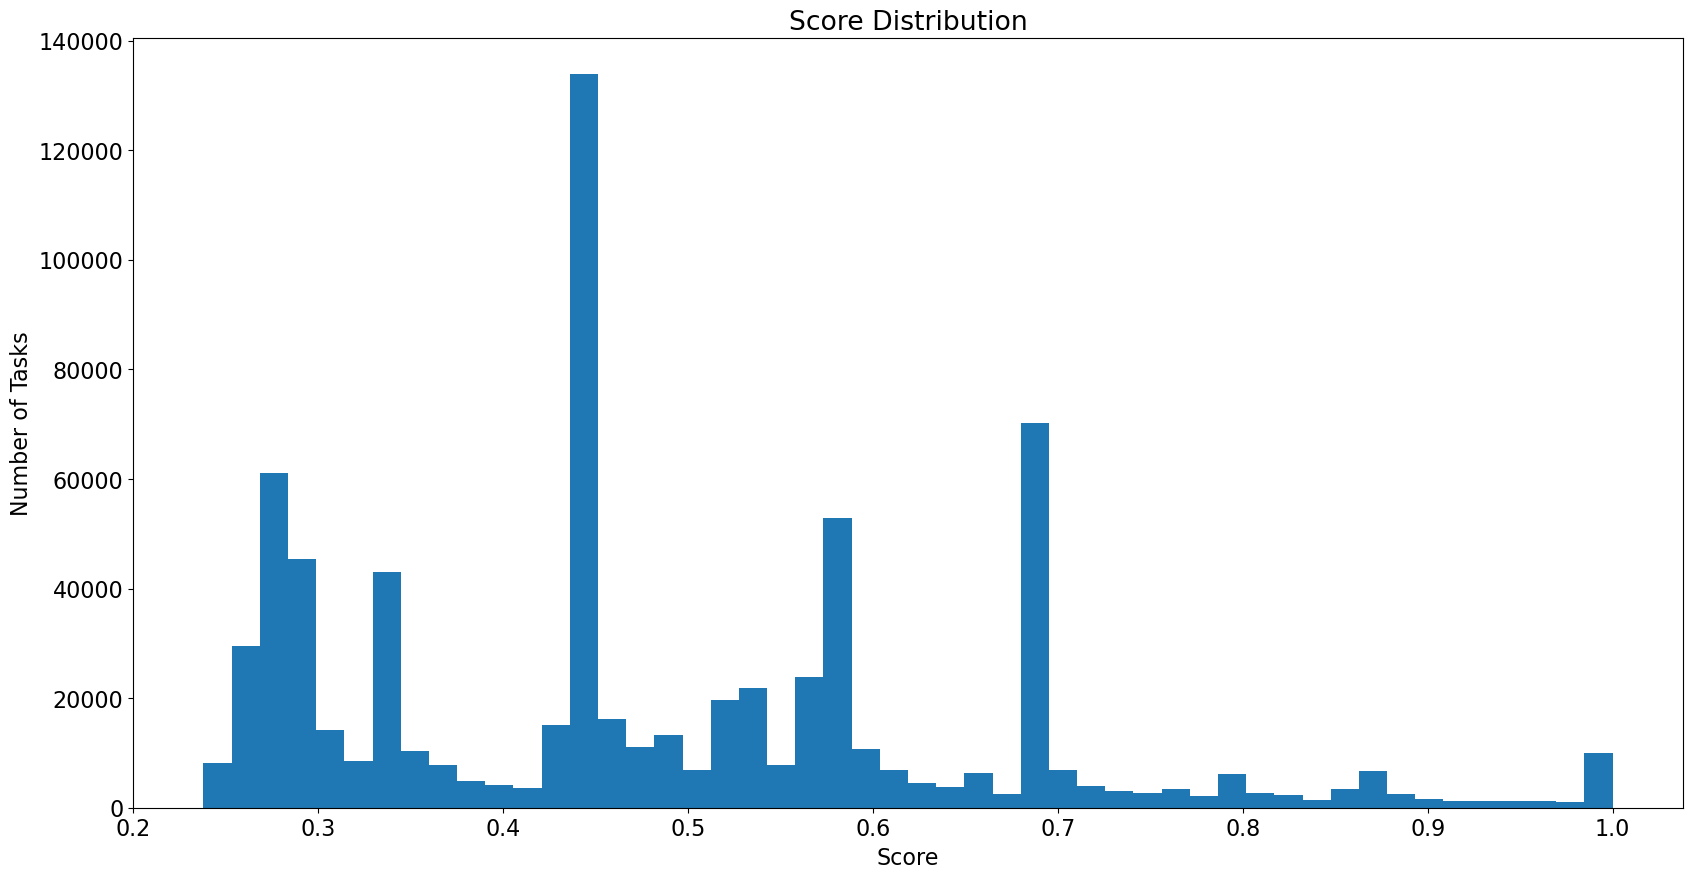

In [55]:
from scipy.stats import norm
import random

filter_dft= term_dft[term_dft['gpu_type'].notnull()] 
# 打印运行时间、plan_gpu中位数、平均值
print('run_time median:',filter_dft['run_time'].median())
print('run_time mean:',filter_dft['run_time'].mean())
print('plan_gpu median:',filter_dft['plan_gpu'].median())
print('plan_gpu mean:',filter_dft['plan_gpu'].mean())
# 新增一列gpu_level，MISC、P100、T4、V100M32、V100分别设置值为1、2、3、4、5，打印相关信息
filter_dft.loc[filter_dft['gpu_type']=='MISC','gpu_level'] = 1
filter_dft.loc[filter_dft['gpu_type']=='P100','gpu_level'] = 2
filter_dft.loc[filter_dft['gpu_type']=='T4','gpu_level'] = 3
filter_dft.loc[filter_dft['gpu_type']=='V100M32','gpu_level'] = 4
filter_dft.loc[filter_dft['gpu_type']=='V100','gpu_level'] = 5
# 打印中位数、平均值
print('gpu_level median:',filter_dft['gpu_level'].median())
print('gpu_level mean:',filter_dft['gpu_level'].mean())

# 为run_time、plan_gpu、gpu_level分别计算z-score，新增三列
filter_dft['run_time_z'] = (filter_dft['run_time'] - filter_dft['run_time'].mean()) / filter_dft['run_time'].std()
filter_dft['plan_gpu_z'] = (filter_dft['plan_gpu'] - filter_dft['plan_gpu'].mean()) / filter_dft['plan_gpu'].std()
filter_dft['gpu_level_z'] = (filter_dft['gpu_level'] - filter_dft['gpu_level'].mean()) / filter_dft['gpu_level'].std()

# 使用z分数为run_time、plan_gpu、gpu_level分别计算一个得分
filter_dft['mean_score'] = (filter_dft['run_time_z'] + filter_dft['plan_gpu_z'] + filter_dft['gpu_level_z']) / 3
# 将score z分数映射到0-1之间，score为0的任务设置为0.5
filter_dft['mean_prob'] = norm.cdf(filter_dft['mean_score'])
# # 根据概率值，将任务分为两类，分别是training和inference，每个任务的概率值代表其为training任务的概率
# filter_dft['task_type'] = filter_dft['mean_prob'].apply(lambda x: 'Training' if random.random() <x else 'Inference')
# 概率值小于0.5的任务设置为inference任务
filter_dft.loc[filter_dft['mean_prob'] < 0.5,'task_type'] = 'Inference'
filter_dft.loc[filter_dft['mean_prob'] >= 0.5,'task_type'] = 'Training'


# 绘制score_norm的分布图
print(filter_dft['mean_prob'].median())
print(filter_dft['mean_prob'].mean())
filter_dft['mean_prob'].plot(kind='hist',bins=50,figsize=(20,10))
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Number of Tasks')
plt.show()


# 只留下job_name、task_name、task_type这三列
save_dft = filter_dft[['job_name','task_name','mean_prob','task_type']]

# 保存处理后的数据
save_dft.to_csv(FILTER_DATA_DIR+'mapping_dft.csv',index=False) # optional
filter_dft.to_csv(FILTER_DATA_DIR+'filter_dft.csv',index=False) # optional

In [4]:
map_dft = pd.read_csv(FILTER_DATA_DIR+'mapping_dft.csv')
term_dft = pd.read_csv(FILTER_DATA_DIR+'term_dft.csv')
# 根据job_name、task_name合并两个表
merge_dft = pd.merge(term_dft,map_dft,on=['job_name','task_name'],how='left')
# 保存处理后的数据
merge_dft.to_csv(FILTER_DATA_DIR+'merge_dft.csv',index=False) # optional
# 删除start_date、end_date、mean_prob这三列
merge_dft.drop(['start_date','end_date','mean_prob','status'],axis=1,inplace=True)
# # 对于 gpu为空的任务，将task_type设置为CPU，plan_gpu设置为0，gpu_type设置为Nan
# merge_dft.loc[merge_dft['gpu_type'].isnull(),'task_type'] = 'CPU'
# merge_dft.loc[merge_dft['gpu_type'].isnull(),'plan_gpu'] = 0
# merge_dft.loc[merge_dft['gpu_type'].isnull(),'gpu_type'] = 'Nan'
# 对于gpu为空的任务，删除这些任务
merge_dft = merge_dft[merge_dft['gpu_type'].notnull()]

# 新增一列，将任务运行时间转换为当日的秒数
merge_dft['start_time_day'] = merge_dft['start_time'] % (24*60*60)
# 新增一列，根据start_time计算任务开始的星期几
merge_dft['start_weekday'] = pd.to_datetime(merge_dft['start_time'],unit='s').dt.weekday



# 保存处理后的数据
merge_dft.to_csv(FILTER_DATA_DIR+'result_dft.csv',index=False) # optional

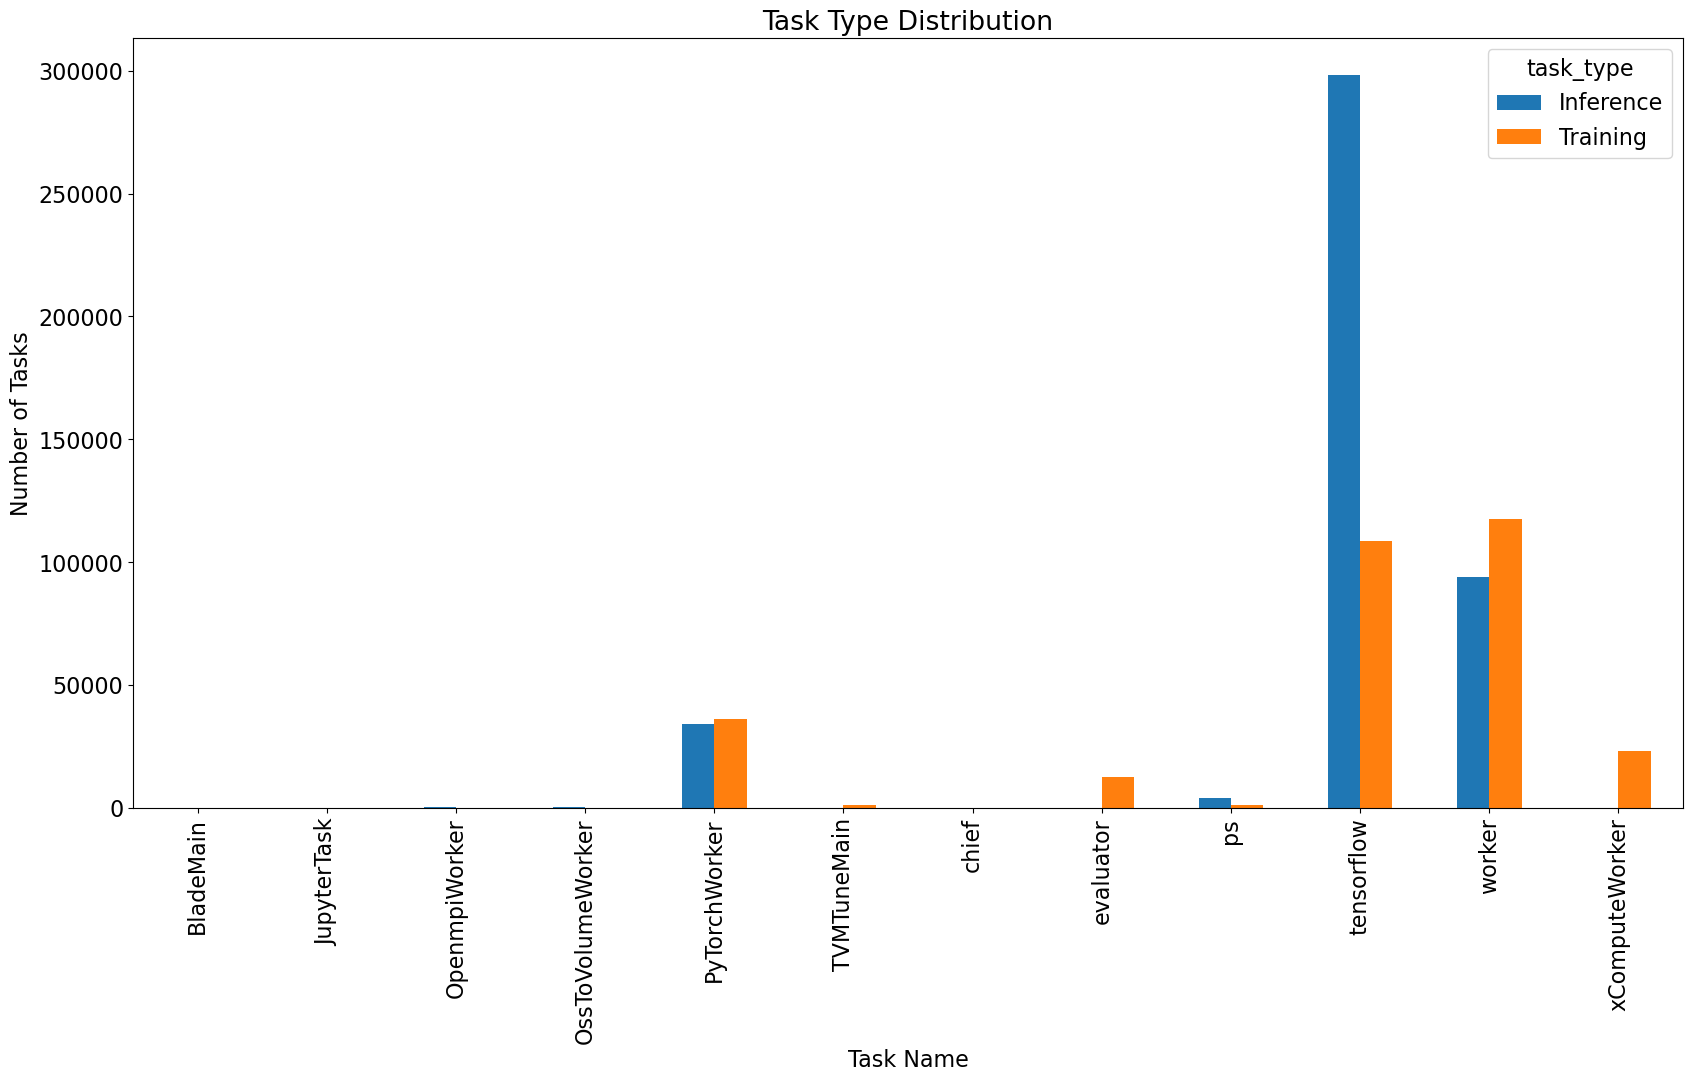

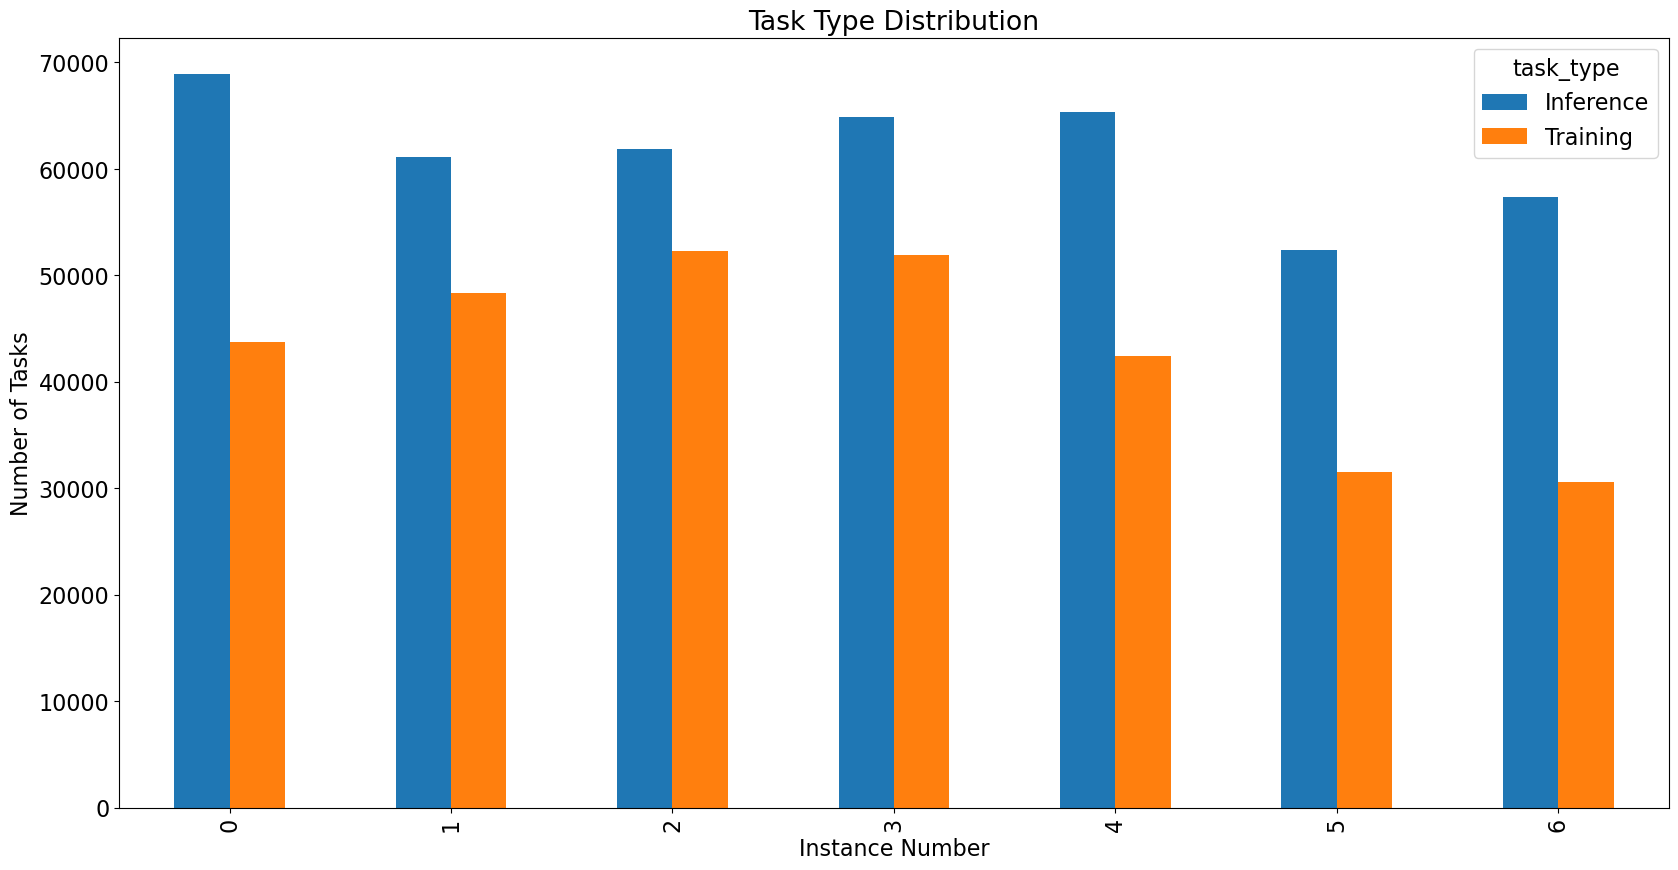

In [57]:


# 打印每种task_name上task_type的分布
merge_dft.groupby('task_name')['task_type'].value_counts().unstack().plot(kind='bar',figsize=(20,10))
plt.title('Task Type Distribution')
plt.xlabel('Task Name')
plt.ylabel('Number of Tasks')
plt.show()
# 打印inst_num上task_type的分布
merge_dft.groupby('start_weekday')['task_type'].value_counts().unstack().plot(kind='bar',figsize=(20,10))
plt.title('Task Type Distribution')
plt.xlabel('Instance Number')
plt.ylabel('Number of Tasks')
plt.show()





In [58]:
import shutil
import os

# 定义原始文件夹路径和目标文件夹路径
source_folder = '../data_filterd'
destination_folder = '../../../predictScale/data'

# 如果目标文件夹已存在，则先删除它
if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

# 使用copytree函数复制文件夹
shutil.copytree(source_folder, destination_folder)

'../../../predictScale/data'

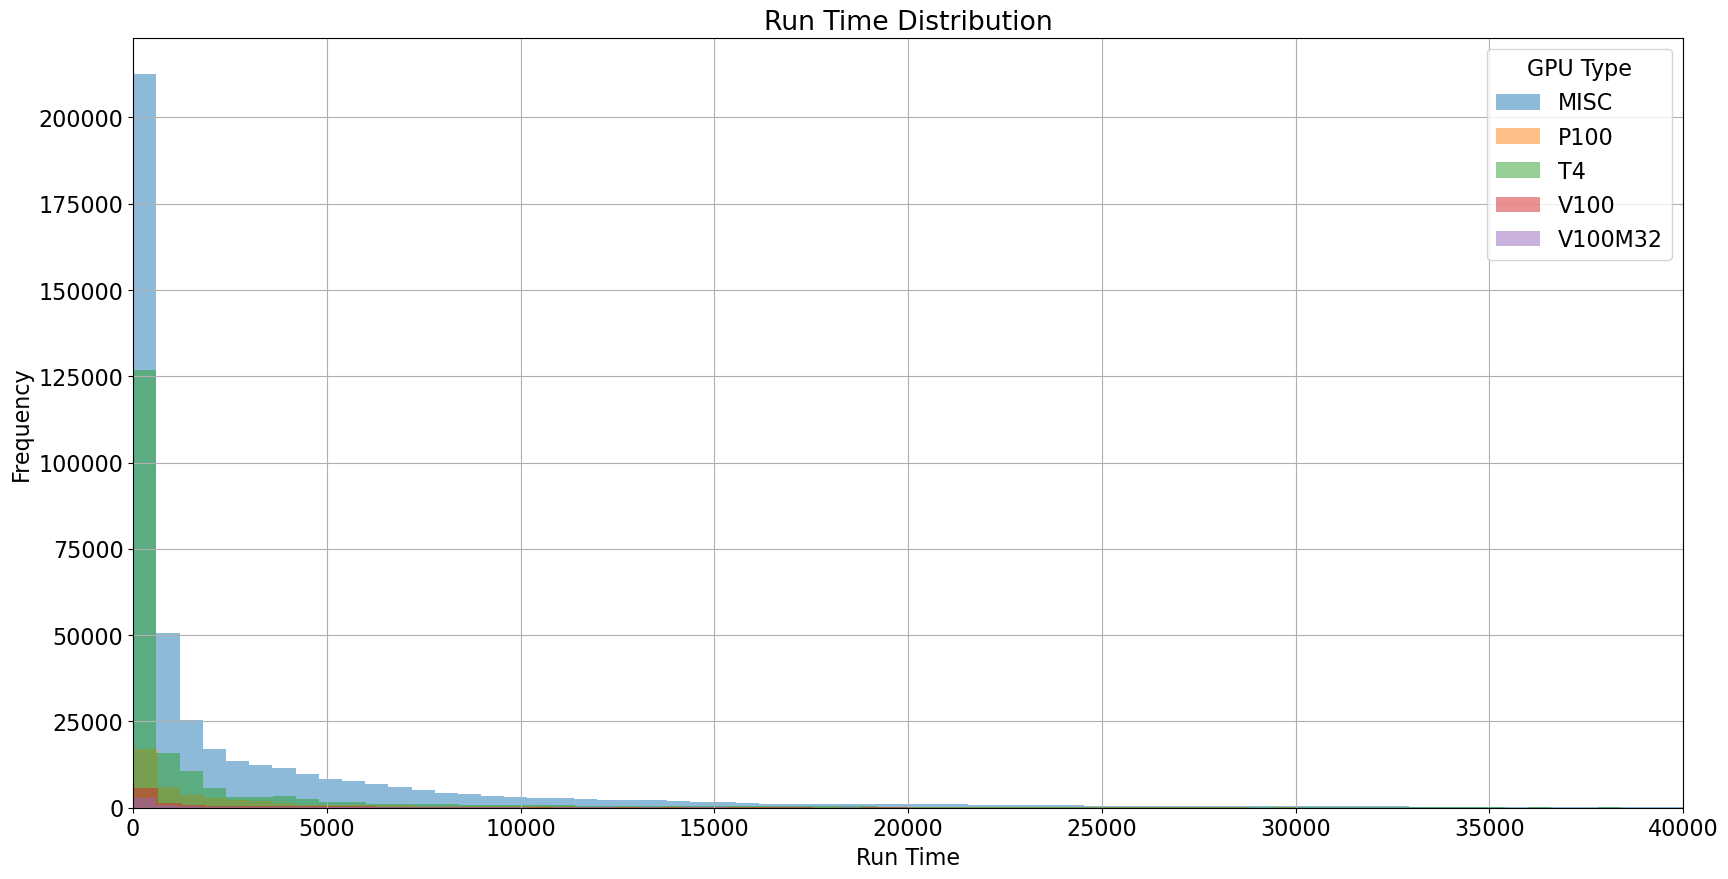

In [92]:

# 分组和绘制直方图
for gpu_type, group in merge_dft.groupby('gpu_type'):
    group['run_time'].hist(bins=1000, alpha=0.5, figsize=(20,10), label=str(gpu_type))

# 增加图标题、轴标签
plt.xlim(0,40000)

plt.title('Run Time Distribution')
plt.xlabel('Run Time')
plt.ylabel('Frequency')

# 绘制图例
plt.legend(title='GPU Type')

# 显示图形
plt.show()

Text(0.5, 1.0, 'Run Time Distribution by GPU Type')

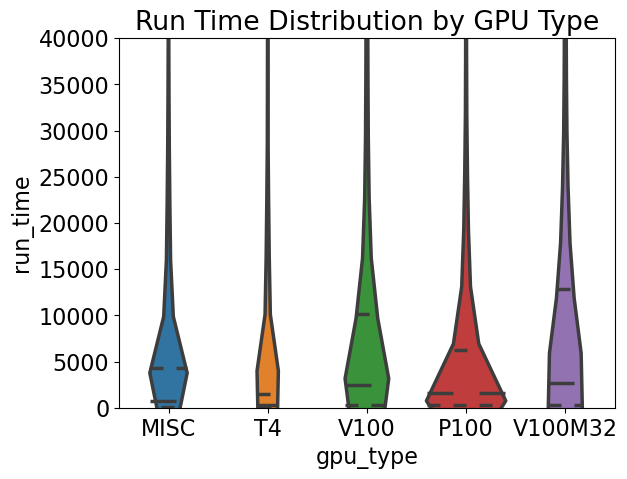

In [91]:
import seaborn as sns

sns.violinplot(x='gpu_type', y='run_time', data=merge_dft, inner="quartile", figsize=(20,10))
plt.ylim(0,40000)
plt.title('Run Time Distribution by GPU Type')

Text(0.5, 1.0, 'Run Time Distribution by GPU Type')

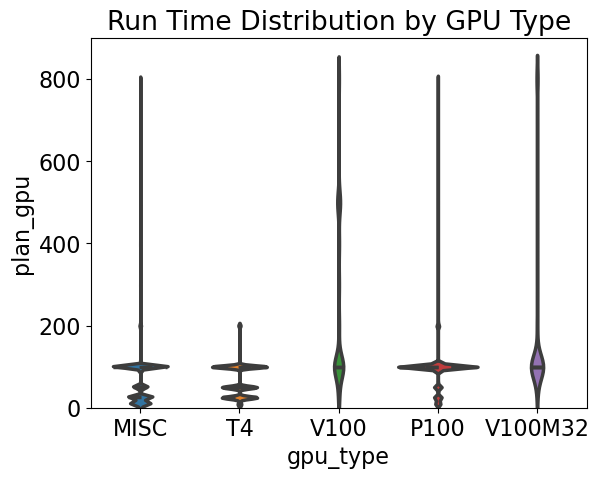

In [96]:
import seaborn as sns

sns.violinplot(x='gpu_type', y='plan_gpu', data=merge_dft, inner="quartile", figsize=(20,10))
plt.ylim(0,900)
plt.title('Run Time Distribution by GPU Type')

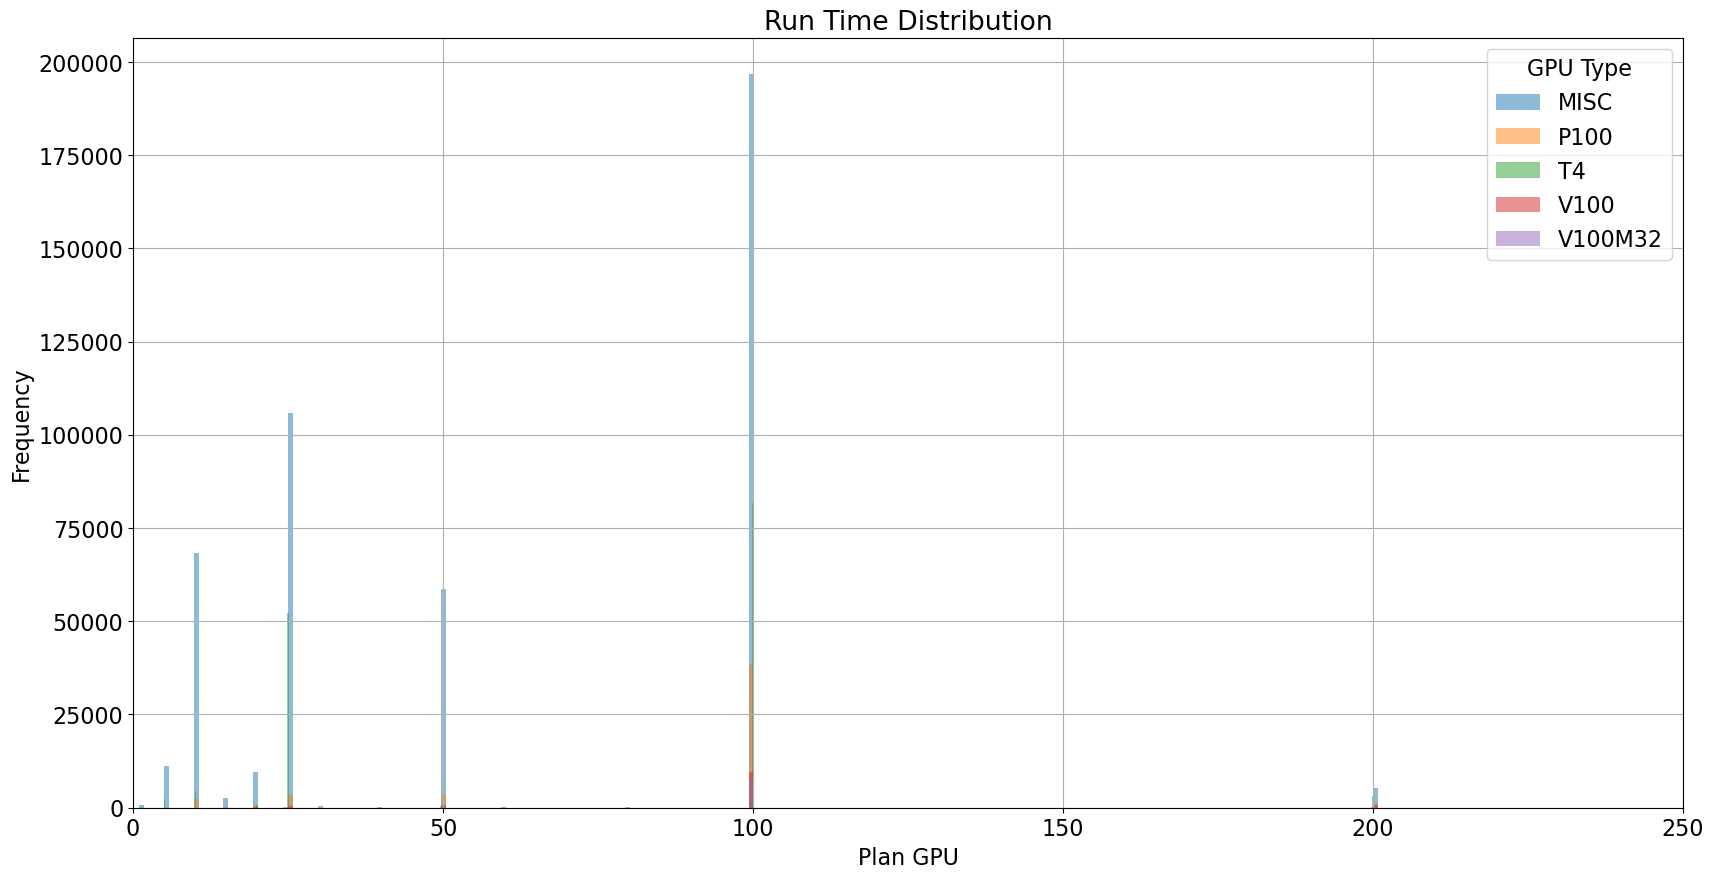

In [5]:

# 分组和绘制折线图
for gpu_type, group in merge_dft.groupby('gpu_type'):
    group['plan_gpu'].hist(bins=1000, alpha=0.5, figsize=(20,10), label=str(gpu_type))

# 增加图标题、轴标签
plt.xlim(0,250)

plt.title('Run Time Distribution')
plt.xlabel('Plan GPU')
plt.ylabel('Frequency')

# 绘制图例
plt.legend(title='GPU Type')

# 显示图形
plt.show()

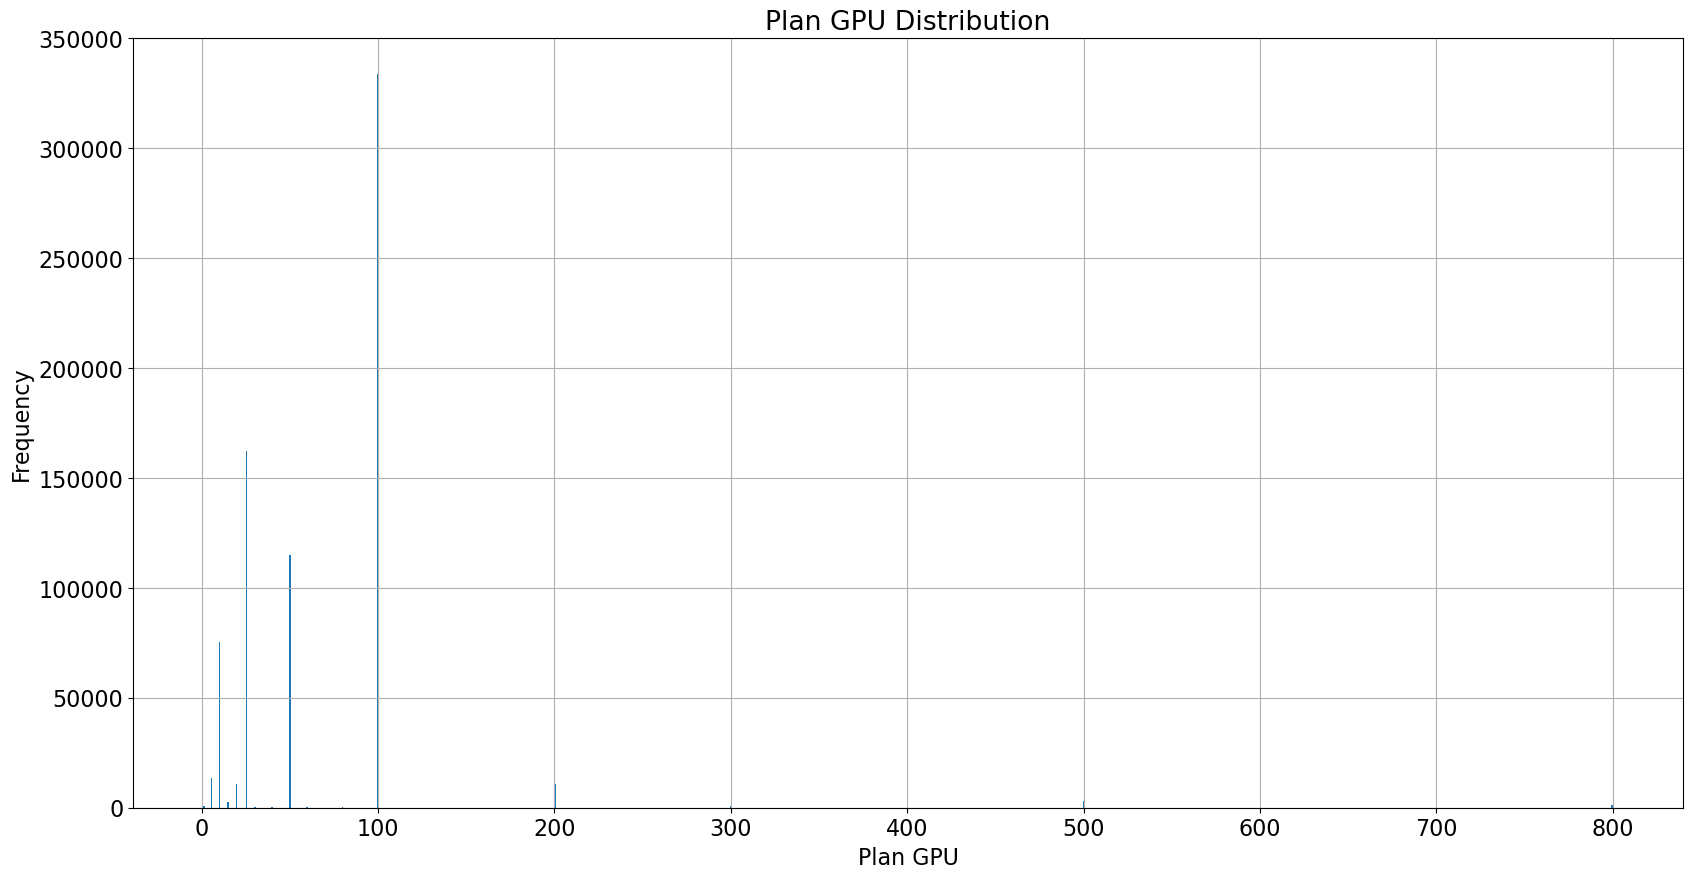

In [17]:
# 打印plan_gpu分布
merge_dft['plan_gpu'].hist(bins=1000, figsize=(20,10))
# plt.xlim(0,250)
plt.title('Plan GPU Distribution')
plt.xlabel('Plan GPU')
plt.ylabel('Frequency')
plt.show()


In [16]:

term_dfp= dfp.drop('machine',axis=1)
# 打印term_dfp的不相同的记录
# print(term_dfp.head())
print(term_dfp.apply(tuple, axis=1).value_counts())

(P100, 64, 512, 2)       798
(T4, 96, 512, 2)         497
(MISC, 96, 512, 8)       280
(V100M32, 96, 384, 8)    135
(CPU, 96, 512, 0)         83
(V100, 96, 512, 8)        59
(V100, 96, 384, 8)        45
Name: count, dtype: int64


In [5]:
dft1=pd.read_csv(FILTER_DATA_DIR+'merge_dft.csv')
# 打印包括null值在内的每种gpu_type的数量
print(dft1['gpu_type'].value_counts(dropna=False))
print(dft1['plan_gpu'].value_counts(dropna=False))
print(dft1[dft1['plan_gpu']==800.0]['gpu_type'].value_counts(dropna=False))

gpu_type
MISC       460346
T4         196219
NaN        152359
P100        50311
V100        16690
V100M32      9045
Name: count, dtype: int64
plan_gpu
100.0    333629
25.0     162099
NaN      152359
50.0     114820
10.0      75273
5.0       13566
20.0      10985
200.0     10842
500.0      3045
15.0       2775
400.0      1475
800.0      1149
300.0       916
1.0         791
30.0        460
60.0        280
40.0        160
80.0        105
75.0         82
600.0        49
150.0        31
95.0         29
70.0         19
90.0         13
2.0           9
55.0          4
700.0         2
8.0           2
65.0          1
Name: count, dtype: int64
gpu_type
V100M32    622
V100       517
MISC         7
P100         3
Name: count, dtype: int64
